In [1]:
import os
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [13]:
class DoubleConv(nn.Module):

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.avgpool_conv = nn.Sequential(
            nn.AvgPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.avgpool_conv(x)


class Up(nn.Module):

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)
class UNet(nn.Module):
    def __init__(self, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = 3
        self.n_classes = 3
        self.bilinear = bilinear

        self.inc = DoubleConv(3, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, 3)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [4]:
def load_images(blur_dir, sharp_dir):
    blur = []  # Renamed from blur_images to blur
    sharp_images = []
    if not os.listdir(blur_dir):
        print("Blur images folder is empty. Please check your data directories.")
        return [], []

    for sharp_file_name in os.listdir(sharp_dir):
        sharp_path = os.path.join(sharp_dir, sharp_file_name)
        if os.path.isfile(sharp_path):
            if sharp_file_name.endswith('.JPG') or sharp_file_name.endswith('.jpg'):
                blur_base_name = sharp_file_name[:-5] 
                blur_file_name = blur_base_name + 'M.jpg' 
            else:
                blur_base_name = sharp_file_name[:-6]  
                blur_file_name = blur_base_name + 'M.jpeg' 
     
            blur_path = os.path.join(blur_dir, blur_file_name)
            if os.path.isfile(blur_path):
                blur_image = Image.open(blur_path)
                sharp_image = Image.open(sharp_path)
                blur.append(blur_image)
                sharp_images.append(sharp_image)
            else:
                print(f"No corresponding blur image found for sharp image: {sharp_file_name}")
    return blur, sharp_images

In [5]:
class ImageDataset(Dataset):
    def __init__(self, blur_images, sharp_images, transform=None):
        self.blur_images = blur_images
        self.sharp_images = sharp_images
        self.transform = transform
    def __len__(self):
        return len(self.blur_images)
    def __getitem__(self, idx):
        blur_image = self.blur_images[idx]
        sharp_image = self.sharp_images[idx]
        if self.transform:
            blur_image = self.transform(blur_image)
            sharp_image = self.transform(sharp_image)
        return blur_image, sharp_image

In [6]:
blur_dir = 'C:\\Users\\jainy\\Downloads\\blur_dataset\\blur_dataset\\motion_blurred'
sharp_dir = 'C:\\Users\\jainy\\Downloads\\blur_dataset\\blur_dataset\\sharp'

In [7]:
blur_images, sharp_images = load_images(blur_dir, sharp_dir)

In [8]:
blur_train, blur_test, sharp_train, sharp_test = train_test_split(blur_images, sharp_images, test_size=0.3, random_state=42)


In [9]:
len(blur_images)

350

In [10]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

In [11]:
train_dataset = ImageDataset(blur_train, sharp_train, transform=transform)
test_dataset = ImageDataset(blur_test, sharp_test, transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False)

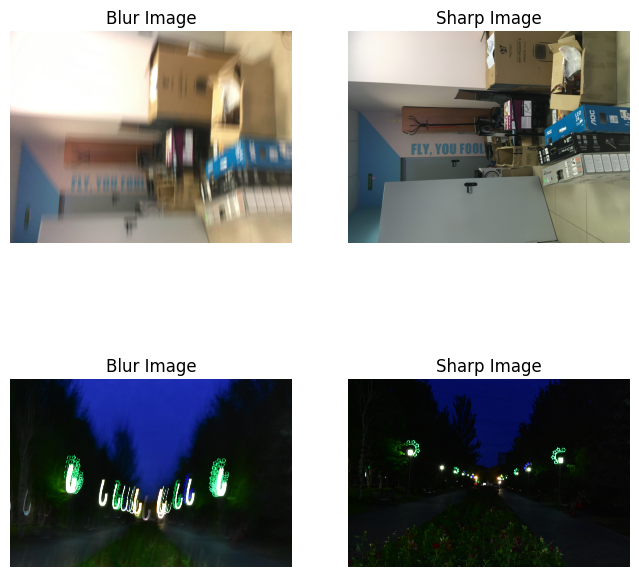

In [12]:
import matplotlib.pyplot as plt
def visualize_sample(dataloader):
    blur, sharp = next(iter(dataloader))
    blur = blur.permute(0, 2, 3, 1).numpy()
    sharp = sharp.permute(0, 2, 3, 1).numpy()

    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    axs[0, 0].imshow(blur_images[0])
    axs[0, 0].set_title("Blur Image")
    axs[0, 1].imshow(sharp_images[0])
    axs[0, 1].set_title("Sharp Image")
    axs[1, 0].imshow(blur_images[1])
    axs[1, 0].set_title("Blur Image")
    axs[1, 1].imshow(sharp_images[1])
    axs[1, 1].set_title("Sharp Image")

    for ax in axs.flat:
        ax.axis('off')

    plt.show()

visualize_sample(train_dataloader)

In [9]:
torch.cuda.is_available()

True

In [10]:
device =  'cuda' if torch.cuda.is_available() else 'cpu'

model = UNet().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 3

In [18]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for blur, sharp in train_dataloader:
        blur = blur.to(device)
        sharp = sharp.to(device)

        optimizer.zero_grad()
        outputs = model(blur)
        loss = criterion(outputs, sharp)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_dataloader)}")
    

Epoch 1/3, Loss: 0.1433073377039859
Epoch 2/3, Loss: 0.048541724477417586
Epoch 3/3, Loss: 0.044574866343925636


In [20]:
torch.save(model.state_dict(), 'best_model.pth')
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

to_pil = transforms.ToPILImage()
output_dir = 'predicted_images'
os.makedirs(output_dir, exist_ok=True)

with torch.no_grad():
    for idx, (blur_img, _) in enumerate(test_dataloader):
        blur_img = blur_img.to(device)
        pred = model(blur_img)
        pred = pred.cpu()

        for i in range(pred.size(0)):
            pred_img = to_pil(pred[i])
            pred_img.save(os.path.join(output_dir, f'predicted_image_{idx * pred.size(0) + i + 1}.jpg'))

print(f'Predicted images saved to {output_dir}')

Predicted images saved to predicted_images
